In [1]:
!pip install tqdm

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


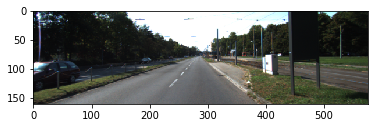

In [2]:
from glob import glob
import scipy.misc
import os.path
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
import cv2

%matplotlib inline

image_shape = (160, 576)

path = os.path.join('data_road', 'testing', 'image_2', 'um_000000.png')
image = scipy.misc.imresize(scipy.misc.imread(path), image_shape)
imshow(np.asarray(image))

In [3]:
def transform_image(img, rotation_range = 20, shear_range = 20, translation_range = 5, brightness = True):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation
    
    '''    
    img = rotate_image(img, rotation_range)
    img = shear_translate_image(img, shear_range)
    img = translate_image(img, translation_range)
    if (brightness):
        img = augument_brightness_image(img)
    return img

def augument_brightness_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    rand_brightness = (np.random.uniform() * .9) + 0.05
    image_hsv[:,:,2] = image_hsv[:, :, 2]*rand_brightness
    return cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)

def rotate_image(image, rotation_range = 20):
    # Rotation
    img_shape = image.shape
    angle_rot = np.random.uniform(rotation_range) - (rotation_range/2)
    rotation_M = cv2.getRotationMatrix2D((img_shape[1]/2, img_shape[0]/2), angle_rot, 1)
    img_rotate = cv2.warpAffine(image,rotation_M,(img_shape[1], img_shape[0]))
    return img_rotate

def shear_translate_image(image, shear_range = 25):
    # Shear Transformation
    img_shape = image.shape
    source_shear_pts = np.float32([[20,20], [40,20], [20, 40]])
    shear_pt1= 20 + np.random.uniform() * shear_range - (shear_range/2)
    shear_pt2 = 40 + np.random.uniform() * shear_range - (shear_range/4)
    dest_shear_pts = np.float32([[shear_pt1, 20], [shear_pt2, shear_pt1], [shear_pt1, 40]])
    
    shear_M = cv2.getAffineTransform(source_shear_pts, dest_shear_pts)
    img_shear = cv2.warpAffine(image,shear_M,(img_shape[1], img_shape[0]))
    return img_shear
    
def translate_image(image, translation_range = 40):
    # Translation
    img_shape = image.shape
    tr_x = translation_range*np.random.uniform()-translation_range/2
    tr_y = translation_range*np.random.uniform()-translation_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    img_translate = cv2.warpAffine(image,Trans_M,(img_shape[1], img_shape[0]))
    return img_translate

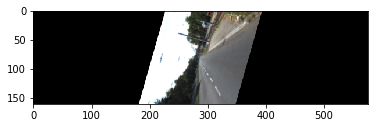

In [4]:
img_rotate = rotate_image(image, rotation_range = 180)
plt.imshow(img_rotate)

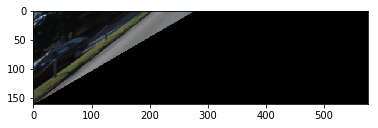

In [5]:
img_shear = shear_translate_image(image, shear_range = 40)
plt.imshow(img_shear)

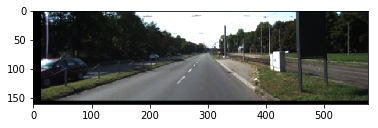

In [6]:
img_translate = translate_image(image, translation_range = 40)
plt.imshow(img_translate)

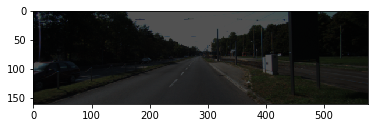

In [7]:
img_brigh_augument = augument_brightness_image(image)
plt.imshow(img_brigh_augument)

In [8]:
import os.path
import tensorflow as tf
import helper
import project_tests as tests
import warnings
from distutils.version import LooseVersion
import scipy.misc
from glob import glob
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

## Check tensorfow version and make sure that it should be greater than 1.0
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using: {}'.format(tf.__version__)
print('Tensorflow version: {}'.format(tf.__version__))

## Check tensorflow gpu device
if not tf.test.gpu_device_name():
  warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
  print('Default GPU device{}'.format(tf.test.gpu_device_name()))

    
def load_vgg(sess, vgg_path):
  """
  Load Pretrained VGG Model into TensorFlow.
  :param sess: TensorFlow Session
  :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
  :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
  """
  vgg_tag = 'vgg16'
  vgg_input_tensor_name = 'image_input:0'
  vgg_keep_prob_tensor_name = 'keep_prob:0'
  vgg_layer3_out_tensor_name = 'layer3_out:0'
  vgg_layer4_out_tensor_name = 'layer4_out:0'
  vgg_layer7_out_tensor_name = 'layer7_out:0'
  tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
  graph = tf.get_default_graph()
  print(tf.trainable_variables())
  input_tensor = graph.get_tensor_by_name(vgg_input_tensor_name)
  prob_tensor = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
  layer3_tensor = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
  layer4_tensor = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
  layer7_tensor = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
  
  return input_tensor, prob_tensor, layer3_tensor, layer4_tensor, layer7_tensor

tests.test_load_vgg(load_vgg, tf)
print ("Load VGG Test passed")


def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
  """
  Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
  :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
  :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
  :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
  :param num_classes: Number of classes to classify
  :return: The Tensor for the last layer of output
  """
  conv_1x1_7 = tf.layers.conv2d(vgg_layer7_out, num_classes, (1,1), padding='same', 
                              kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
  ## Upsample deconvolution x2
  first_upsample_7x2 = tf.layers.conv2d_transpose(conv_1x1_7, num_classes, (4,4), strides=(2,2), 
                                      padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
  
  conv_1x1_4 = tf.layers.conv2d(vgg_layer4_out, num_classes, (1,1), padding='same', 
                              kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
  
  ## First skip layer
  first_skip_7_4 = tf.add(first_upsample_7x2, conv_1x1_4, name='first_skip')
  
  ## Upsample deconvolution x2
  second_upsample_7x2 = tf.layers.conv2d_transpose(first_skip_7_4, num_classes, (4,4), strides=(2,2), 
                                      padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
  
  conv_1x1_3 = tf.layers.conv2d(vgg_layer3_out, num_classes, (1,1), padding='same', 
                              kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
  
  ## Second skip layer
  second_skip_7_3 = tf.add(second_upsample_7x2, conv_1x1_3, name='second_skip')
  
  ## Upsample deconvolution x8
  third_upsample_7x8 = tf.layers.conv2d_transpose(second_skip_7_3, num_classes, (16,16), strides=(8,8), 
                                      padding='same', kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3), name='last_layer')
  return third_upsample_7x8

tests.test_layers(layers)
print ("Layers Test passed")
  
  
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name='logits')
    labels = tf.reshape(correct_label, (-1, num_classes), name ='reshaped_labels')
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels), name="loss")
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss, name='train_operation')
    iou, conf_matrix = tf.metrics.mean_iou(labels, logits,num_classes = num_classes,name="iou")
    return logits, train_op, cross_entropy_loss, iou
  
#tests.test_optimize(optimize)
#print ("Optimize Test passed")
  
def evaluate(sess, nn_last_layer, correct_label, input_image, get_batches_fn, num_classes, batch_size, keep_prob, logits, reshape_labels):
  iou,conf_mat = tf.metrics.mean_iou( predictions=logits, labels = reshape_labels, num_classes=num_classes,name="iou")
  #iou_summary = tf.summary.scalar("IoU", iou)
  total_iou = 0;
  for images_batch, labels_batch in get_batches_fn(batch_size):
    train_iou = sess.run(iou, feed_dict={input_image:images_batch, correct_label: labels_batch, keep_prob:1})
    total_iou += train_iou * batch_size;
    print ("Total IOU: {} and mean IOU{}".format(total_iou, train_iou))
  
  total_iou = total_iou/289
  print ("Mean IOU value {}".format(total_iou))
  return total_iou

  
  
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate, iou):
  """
  Train neural network and print out the loss during training.
  :param sess: TF Session
  :param epochs: Number of epochs
  :param batch_size: Batch size
  :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
  :param train_op: TF Operation to train the neural network
  :param cross_entropy_loss: TF Tensor for the amount of loss
  :param input_image: TF Placeholder for input images
  :param correct_label: TF Placeholder for label images
  :param keep_prob: TF Placeholder for dropout keep probability
  :param learning_rate: TF Placeholder for learning rate
  """
  # Initialize all the global variables and local variables for IOU computation
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())
  for i in range(epochs):
    counter = 0
    losses = 0
    total_iou = 0
    for images_batch, labels_batch in get_batches_fn(batch_size):
      _, loss = sess.run([train_op, cross_entropy_loss], feed_dict={input_image:images_batch, correct_label: labels_batch, keep_prob:0.5})
      losses += loss
      #total_iou += train_iou
      #print ("Loss of batch is {:3f}".format(loss))
        
      
    print("Training finished")
    print ("Epoch {} ....".format(i))
    print ("Total average loss is {:3f}".format((losses * (batch_size))/289))
            
def run():
  num_classes = 2
  image_shape = (160, 576)
  data_dir = './data'
  runs_dir = './run'
  EPOCHS_NUM = 50
  BATCH_SIZE = 5
  learning_rate = 0.0009
  correct_label = tf.placeholder(tf.int32, shape=[None, image_shape[0], image_shape[1], num_classes], name="correct_labels")
  #input_image = tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], 3], name="input_images")
  
  ## Download VGG model
  helper.maybe_download_pretrained_vgg(data_dir)
  
  # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
  # You'll need a GPU with at least 10 teraFLOPS to train on.
  #  https://www.cityscapes-dataset.com/
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  with tf.Session(config=config) as sess:
    # Path to vgg model.
    vgg_path = os.path.join(data_dir, 'vgg')
    get_batches_fn = helper.gen_batch_function(os.path.join('data_road', 'training'), image_shape)
    # OPTIONAL: Augment Images for better results
    #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

    # TODO: Build NN using load_vgg, layers, and optimize function
    input_tensor, prob_tensor, layer3_tensor, layer4_tensor, layer7_tensor = load_vgg(sess, vgg_path)
    nn_last_layer = layers(layer3_tensor, layer4_tensor, layer7_tensor, num_classes)
    logits, train_op, cross_entropy_loss, iou = optimize(nn_last_layer, correct_label, learning_rate, num_classes)
    ##operations = sess.graph.get_operations()
    #print ("Name of all the operations: ")
    ##for op in operations:
        ##print (op.name)
    
    saver = tf.train.Saver(max_to_keep=1)
    # TODO: Train NN using the train_nn function
    train_nn(sess, EPOCHS_NUM, BATCH_SIZE, get_batches_fn, 
             train_op, cross_entropy_loss, input_tensor, correct_label, prob_tensor, learning_rate, iou)
    
    savePath = saver.save(sess, "savedModels/vggRoadModel.ckpt")
    print ("Model saved and path is {}".format(savePath))
    # TODO: Save inference data using helper.save_inference_samples
    helper.save_inference_samples(runs_dir, 'data_road', sess, image_shape, logits, prob_tensor, input_tensor)
    # Test inference of the model
    test_img = os.path.join('data_road', 'testing', 'image_2', 'um_000000.png')
    image = scipy.misc.imresize(scipy.misc.imread(test_img), image_shape)
    im_softmax = sess.run(
            [tf.nn.softmax(logits)],
            {prob_tensor: 1.0, input_image: [image]})
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    street_im = scipy.misc.toimage(image)
    street_im.paste(mask, box=None, mask=mask)
    imshow(np.asarray(street_im))
    scipy.misc.imsave('testOutputs/ouput.png', street_im)
    
    # OPTIONAL: Apply the trained model to a video

run()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version: 1.5.0
Default GPU device/device:GPU:0
[]
Tests Passed
Load VGG Test passed
Tests Passed
Layers Test passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
[<tf.Variable 'conv1_1/filter:0' shape=(3, 3, 3, 64) dtype=float32_ref>, <tf.Variable 'conv1_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv1_2/filter:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'conv1_2/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2_1/filter:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'conv2_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'conv2_2/filter:0' shape=(3, 3, 128, 128) dtype=float32_ref>, <tf.Variable 'conv2_2/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'conv3_1/filter:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'conv3_1/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'conv3_2/filter:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'conv3_2/biases:

Saving image with dir : ./run/images/uu_000056.png
Saving image with dir : ./run/images/umm_000047.png
Saving image with dir : ./run/images/uu_000020.png
Saving image with dir : ./run/images/um_000069.png
Saving image with dir : ./run/images/uu_000003.png
Saving image with dir : ./run/images/uu_000023.png
Saving image with dir : ./run/images/um_000086.png
Saving image with dir : ./run/images/uu_000083.png
Saving image with dir : ./run/images/umm_000044.png
Saving image with dir : ./run/images/um_000047.png
Saving image with dir : ./run/images/umm_000066.png
Saving image with dir : ./run/images/umm_000053.png
Saving image with dir : ./run/images/um_000077.png
Saving image with dir : ./run/images/umm_000008.png
Saving image with dir : ./run/images/uu_000041.png
Saving image with dir : ./run/images/umm_000051.png
Saving image with dir : ./run/images/um_000021.png
Saving image with dir : ./run/images/uu_000046.png
Saving image with dir : ./run/images/uu_000080.png
Saving image with dir : .

Saving image with dir : ./run/images/um_000073.png
Saving image with dir : ./run/images/um_000014.png
Saving image with dir : ./run/images/umm_000050.png
Saving image with dir : ./run/images/um_000022.png
Saving image with dir : ./run/images/uu_000038.png
Saving image with dir : ./run/images/uu_000042.png
Saving image with dir : ./run/images/uu_000034.png
Saving image with dir : ./run/images/um_000094.png
Saving image with dir : ./run/images/um_000082.png
Saving image with dir : ./run/images/um_000013.png
Saving image with dir : ./run/images/um_000016.png
Saving image with dir : ./run/images/um_000000.png
Saving image with dir : ./run/images/umm_000004.png
Saving image with dir : ./run/images/uu_000064.png
Saving image with dir : ./run/images/umm_000061.png
Saving image with dir : ./run/images/uu_000059.png
Saving image with dir : ./run/images/umm_000075.png
Saving image with dir : ./run/images/um_000029.png
Saving image with dir : ./run/images/umm_000002.png
Saving image with dir : ./

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:207: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:207: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


NameError: name 'input_image' is not defined

In [ ]:
def freeze_graph(model_dir):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant"""
    if not tf.gfile.Exists(model_dir):
        raise AssertionError("Export directory doesn't exists."
                             "Please specify an export directory {}".format(model_dir))
    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + "/frozen_model.pb"
    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True
    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)
        # We restore the weights
        saver.restore(sess, input_checkpoint)

In [ ]:
## Restore model and run some tests on the model
training_img_path = os.path.join(data_folder, 'image_2', '*.png')
saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore variables from disk.
    ckpt = tf.train.get_checkpoint_state('./model/')
    saver.restore(sess, "savedModels/vggRoadModel.ckpt")
    sess.run([train_op, cross_entropy_loss], feed_dict={input_image:images_batch, correct_label: labels_batch, keep_prob:0.9})
    print("Model restored.")